# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [3]:
!pip install albumentations labelme

### 1.2 Collect Images Using OpenCV

In [4]:
import os
import time
import uuid
import cv2

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [7]:
!labelme

zsh:1: command not found: labelme


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [7]:
# Define parameters

# batch_size = 32
# img_height = 180
# img_width = 180


In [8]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_PATH,
#   validation_split=0.2,
#   subset='training',
#   labels='inferred',
#   shuffle=False,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Found 90 files belonging to 2 classes.
Using 72 files for training.
Metal device set to: Apple M1


2023-01-04 11:02:53.877615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 11:02:53.878049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# test_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_PATH,
#   validation_split=0.2,
#   subset='validation',
#   labels='inferred',
#   shuffle=False,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Found 90 files belonging to 2 classes.
Using 18 files for validation.


In [10]:
# train,val= tf.keras.utils.split_dataset(
#     train_ds, left_size=0.9, right_size=0.1, shuffle=False, seed=None
# )

2023-01-04 11:04:11.656063: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's write our own input pipeline using tf.data.

In [9]:
images = tf.data.Dataset.list_files(('data/images/*.jpg'), shuffle=False)

Metal device set to: Apple M1


2023-03-16 14:03:59.434802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 14:03:59.435762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The following command will just show the full image path.

In [10]:
images.as_numpy_iterator().next()


b'data/images/1e18f792-627f-11ed-a7d4-aec04a7949b3.jpg'

The function load_image takes the image path and returns the image. After that we will map this function to all the elements of the tensorflow dataset.

In [11]:
def load_image(filename): 
    byte_img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

Now, if we run the same command as before, it won't return the image path but the image.

In [13]:
images.as_numpy_iterator().next()

2023-03-16 14:04:16.787337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[  0,   1,   3],
        [  2,   3,   5],
        [  2,   3,   5],
        ...,
        [ 42,  97, 190],
        [ 80, 140, 236],
        [ 87, 151, 248]],

       [[  0,   1,   3],
        [  1,   2,   4],
        [  2,   3,   5],
        ...,
        [ 81, 142, 233],
        [100, 166, 255],
        [ 94, 164, 255]],

       [[  0,   1,   3],
        [  1,   2,   4],
        [  2,   3,   5],
        ...,
        [102, 176, 255],
        [ 79, 160, 249],
        [ 78, 163, 253]],

       ...,

       [[  8,  22,  23],
        [  1,  15,  16],
        [  0,  11,  12],
        ...,
        [  6,  19,  35],
        [  2,  15,  31],
        [ 10,  23,  39]],

       [[ 11,  23,  23],
        [  4,  16,  16],
        [  0,  10,  10],
        ...,
        [ 10,  23,  39],
        [  1,  14,  30],
        [  8,  21,  37]],

       [[  4,  16,  16],
        [ 12,  24,  24],
        [  0,  12,  12],
        ...,
        [  1,  14,  30],
        [  0,  13,  29],
        [  2,  15,  31]]

In [14]:
len(images)

90

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

plot_images = image_generator.next()

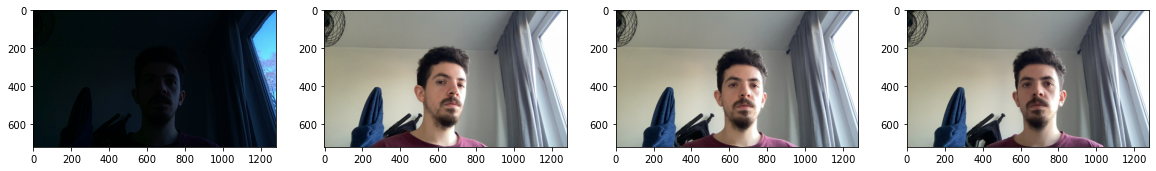

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Apply Image Augmentation on Images and Labels using Albumentations

### 3.1 Setup Albumentations Transform Pipeline

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [19]:
img = cv2.imread(os.path.join('data','images','1ec051e0-627f-11ed-a7d4-aec04a7949b3.jpg'))

I will use the shape method to get the height and width of the image. I will need this when I rescale the coordinates later.

In [20]:
img.shape

(720, 1280, 3)

In [21]:
with open(os.path.join('data', 'labels', '1ec051e0-627f-11ed-a7d4-aec04a7949b3.json'), 'r') as f:
    label = json.load(f)

In [22]:
label['shapes'][0]['points']

[[491.90476190476187, 201.42857142857142],
 [763.3333333333334, 607.1428571428571]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [24]:
coords

[491.90476190476187, 201.42857142857142, 763.3333333333334, 607.1428571428571]

Now I need to rescale the coordinates by dividing  coordinates in pixels for the x- and y-axis by the width and the height of the image. This is because we are using the albumentations bounding box format (which was specified in the augmentor variable).

In [25]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [26]:
coords

[0.38430059523809523,
 0.27976190476190477,
 0.5963541666666667,
 0.8432539682539683]

### 4.4 Apply Augmentations and View Results

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [28]:
augmented['bboxes'][0]

(0.0, 0.1685714285714286, 0.44021164021164016, 1.0)

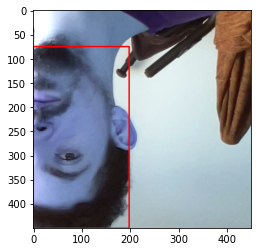

In [29]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [30]:

    for image in os.listdir(os.path.join('data','images')):
        img = cv2.imread(os.path.join('data','images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.29575892857142855, 0.8736772486772486, 0.5420386904761905, 0.21891534391534392, 'face'].
image must be numpy array type
y_max is less than or equal to y_min for bbox [0.39843749999999994, 0.9133597883597884, 0.5985863095238095, 0.3657407407407408, 'face'].
y_max is less than or equal to y_min for bbox [0.4482886904761905, 0.912037037037037, 0.6581101190476191, 0.3498677248677249, 'face'].
y_max is less than or equal to y_min for bbox [0.49813988095238093, 0.8789682539682541, 0.7206101190476191, 0.2572751322751322, 'face'].
y_max is less than or equal to y_min for bbox [0.44382440476190477, 0.8855820105820106, 0.6521577380952381, 0.3128306878306878, 'face'].
y_max is less than or equal to y_min for bbox [0.36197916666666663, 0.8816137566137567, 0.6164434523809523, 0.12764550264550265, 'face'].
y_max is less than or equal to y_min for bbox [0.3917410714285714, 0.9041005291005291, 0.6142113095238095, 0.3326719576719576, 'face'].
y_max is le

### 5.2 Load Augmented Images to Tensorflow Dataset

In [31]:
list_images = tf.data.Dataset.list_files('aug_data/images/*.jpg', shuffle=False)
list_images = list_images.map(load_image)
list_images = list_images.map(lambda x: tf.image.resize(x, (120,120)))
list_images = list_images.map(lambda x: x/255)

In [32]:
len(list_images)

4440

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [34]:
list_labels = tf.data.Dataset.list_files('aug_data/labels/*.json', shuffle=False)
list_labels = list_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
list_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check dataset lengths

First, let's make sure both the images and labels dataset have the same length.

In [36]:
print(len(list_images))
print(len(list_labels))

4440
4440


### 7.2 Create the final dataset by zipping the images and labels datasets together.

In [37]:
list_ds = tf.data.Dataset.zip((list_images, list_labels))


In [38]:
list_ds.as_numpy_iterator().next()

(array([[[0.02518382, 0.07371324, 0.11636029],
         [0.06017157, 0.09938726, 0.14289215],
         [0.05441177, 0.09362745, 0.13284314],
         ...,
         [0.02953431, 0.06875   , 0.10404412],
         [0.01623775, 0.05545343, 0.09074755],
         [0.00980392, 0.04803922, 0.07401961]],
 
        [[0.03541667, 0.08547794, 0.12058824],
         [0.06115196, 0.11084559, 0.14656863],
         [0.03670343, 0.07689951, 0.12395833],
         ...,
         [0.00153186, 0.0213848 , 0.05667892],
         [0.01660539, 0.05625   , 0.09025735],
         [0.01911765, 0.05735294, 0.07843138]],
 
        [[0.0182598 , 0.05453431, 0.07720588],
         [0.04050245, 0.09148284, 0.12334559],
         [0.02910539, 0.07616422, 0.12322304],
         ...,
         [0.01893382, 0.05422794, 0.08167892],
         [0.02254902, 0.05784314, 0.08529412],
         [0.01875   , 0.04914216, 0.07904412]],
 
        ...,
 
        [[0.01231618, 0.03976716, 0.06329657],
         [0.01164216, 0.03909314, 0.06262

### 7.3 Split the dataset into training, validation and testing sets.

Now that we loaded the augmented images and labels into the tensorflow pipeline, it's time to split them into training, validation and testing datasets. First, I will divide the dataset into training and validation. After that, I will split the validation set into testing and validation.

In [39]:
image_count = len(list_ds)
val_size = int(image_count * 0.3)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [40]:
val_image_count = len(val_ds)
test_size = int(val_image_count * 0.6)
val_ds = val_ds.skip(test_size)
test_ds = val_ds.take(test_size)

Let's print the lengths of all 3 datasets to make sure that the splitting worked.

In [41]:
print(len(train_ds))

print(len(val_ds))

print(len(test_ds))

3108
533
533


### 7.3 Batch and prefetch the datasets.

Now let's combine consecutive elements of the datasets into batches of 8 and add a call to prefetch, which avoids bottlenecks while loading and training data.

In [42]:
train_ds = train_ds.shuffle(len(train_ds))
train_ds = train_ds.batch(8)
train_ds = train_ds.prefetch(4)

val_ds = val_ds.shuffle(len(val_ds))
val_ds = val_ds.batch(8)
val_ds = val_ds.prefetch(4)

test_ds = test_ds.shuffle(len(test_ds))
test_ds = test_ds.batch(8)
test_ds= test_ds.prefetch(4)

### 7.4 View Images and Annotations

In [43]:
data_samples = train_ds.as_numpy_iterator()

In [44]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


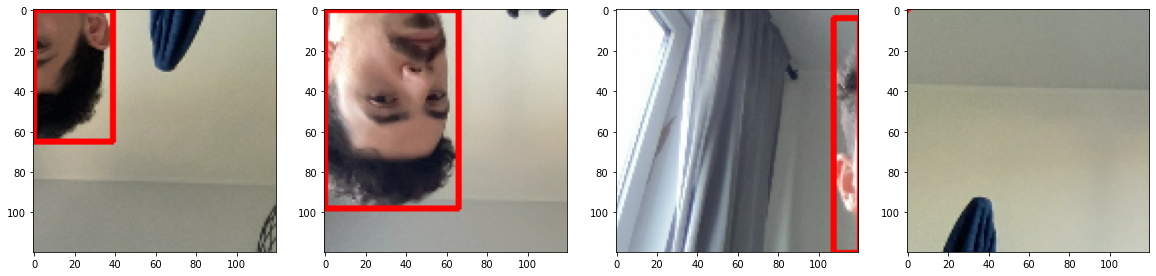

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [47]:
vgg = VGG16(include_top=False)

In [48]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [49]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [50]:
facetracker = build_model()

In [51]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [52]:
X, y = train_ds.as_numpy_iterator().next()

In [53]:
X.shape

(8, 120, 120, 3)

In [54]:
y

(array([[1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.      , 0.009315, 0.281   , 0.8984  ],
        [0.7876  , 0.01037 , 1.      , 0.821   ],
        [0.      , 0.3716  , 0.3232  , 1.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.06433 , 0.6772  ],
        [0.632   , 0.      , 1.      , 0.656   ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [55]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 186ms/step


2023-03-16 14:43:54.486485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [56]:
classes, coords

(array([[0.43311074],
        [0.5691185 ],
        [0.5902069 ],
        [0.54515463],
        [0.46376228],
        [0.5588801 ],
        [0.4423385 ],
        [0.45991972]], dtype=float32),
 array([[0.39858264, 0.5512825 , 0.29814038, 0.56027186],
        [0.33954734, 0.5098107 , 0.3809227 , 0.5573594 ],
        [0.4192711 , 0.6121581 , 0.2620292 , 0.58253616],
        [0.43887493, 0.71689355, 0.31626773, 0.510899  ],
        [0.4599646 , 0.6548228 , 0.44367793, 0.5149071 ],
        [0.43971443, 0.5625178 , 0.3056017 , 0.6589833 ],
        [0.43573272, 0.56152713, 0.35936436, 0.62485814],
        [0.45487642, 0.6621585 , 0.4258778 , 0.56053305]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [57]:
batches_per_epoch = len(train_ds)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [59]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [61]:
classloss(y[0], classes).numpy()

0.6690277

In [62]:
regressloss(y[1], coords).numpy()

7.201519

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [63]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [64]:
model = FaceTracker(facetracker)

In [65]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [66]:
logdir='logs'

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [68]:
hist = model.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/40


2023-03-16 14:44:52.659729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


389/389 [==============================] - ETA: 0s - total_loss: 0.6175 - class_loss: 0.1255 - regress_loss: 0.5547

2023-03-16 14:45:56.368641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


389/389 [==============================] - 69s 163ms/step - total_loss: 0.6160 - class_loss: 0.1252 - regress_loss: 0.5534 - val_total_loss: 0.0509 - val_class_loss: 0.0525 - val_regress_loss: 0.0246
Epoch 2/40
389/389 [==============================] - 68s 162ms/step - total_loss: 0.1952 - class_loss: 0.0566 - regress_loss: 0.1669 - val_total_loss: 0.1923 - val_class_loss: 0.0338 - val_regress_loss: 0.1754
Epoch 3/40
389/389 [==============================] - 68s 163ms/step - total_loss: 0.1516 - class_loss: 0.0498 - regress_loss: 0.1267 - val_total_loss: 0.1220 - val_class_loss: 0.0685 - val_regress_loss: 0.0877
Epoch 4/40
389/389 [==============================] - 69s 165ms/step - total_loss: 0.1365 - class_loss: 0.0427 - regress_loss: 0.1152 - val_total_loss: 0.2716 - val_class_loss: 0.0558 - val_regress_loss: 0.2437
Epoch 5/40
389/389 [==============================] - 68s 164ms/step - total_loss: 0.1194 - class_loss: 0.0396 - regress_loss: 0.0996 - val_total_loss: 0.0193 - val_cl

2023-03-16 15:23:56.465672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 68 of 3108
2023-03-16 15:23:56.468024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 69 of 3108
2023-03-16 15:23:56.469988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 70 of 3108
2023-03-16 15:23:56.472384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 71 of 3108
2023-03-16 15:23:56.475912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 72 of 3108
2023-03-16 15:23:56.479477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 73 of 3108
2023-03-16 15:23:56.492670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer 

  1/389 [..............................] - ETA: 25:58:33 - total_loss: 0.0115 - class_loss: 0.0017 - regress_loss: 0.0106

2023-03-16 15:24:00.768444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


389/389 [==============================] - 305s 165ms/step - total_loss: 0.0137 - class_loss: 0.0031 - regress_loss: 0.0121 - val_total_loss: 0.0096 - val_class_loss: 2.8590e-06 - val_regress_loss: 0.0096
Epoch 30/40
389/389 [==============================] - 68s 163ms/step - total_loss: 0.0065 - class_loss: 0.0015 - regress_loss: 0.0057 - val_total_loss: 0.0047 - val_class_loss: 5.9361e-05 - val_regress_loss: 0.0047
Epoch 31/40
389/389 [==============================] - 69s 164ms/step - total_loss: 0.0054 - class_loss: 0.0012 - regress_loss: 0.0048 - val_total_loss: 0.0025 - val_class_loss: 5.7228e-04 - val_regress_loss: 0.0022
Epoch 32/40
389/389 [==============================] - 69s 163ms/step - total_loss: 0.0048 - class_loss: 9.5665e-04 - regress_loss: 0.0043 - val_total_loss: 2.6166 - val_class_loss: 1.7484 - val_regress_loss: 1.7424
Epoch 33/40
389/389 [==============================] - 69s 164ms/step - total_loss: 0.0057 - class_loss: 0.0010 - regress_loss: 0.0051 - val_total_

### 10.3 Plot Performance

In [69]:
hist.history

{'total_loss': [0.050014927983284,
  0.03140599653124809,
  0.8296141624450684,
  0.06033831462264061,
  0.021237369626760483,
  0.01224513165652752,
  0.005386223550885916,
  0.023740461096167564,
  0.03294043242931366,
  0.02115008607506752,
  0.002065779408439994,
  0.0024642925709486008,
  0.014238851144909859,
  0.008996531367301941,
  0.011334429495036602,
  0.005065551493316889,
  0.008211963810026646,
  0.0037356645334511995,
  0.0015703154494985938,
  0.00472576729953289,
  0.004506845027208328,
  0.0011969506740570068,
  0.003511435352265835,
  0.0008802132215350866,
  0.000804574228823185,
  0.0005067625897936523,
  0.0006279301596805453,
  0.020608773455023766,
  0.0007940163486637175,
  0.000877698534168303,
  0.0007915084715932608,
  0.0009673881577327847,
  0.0008025416173040867,
  0.002417051000520587,
  0.0008631969103589654,
  0.0008205725462175906,
  9.009119094116613e-05,
  0.0018632588908076286,
  0.0007822722545824945,
  0.0010894772130995989],
 'class_loss': [0.0

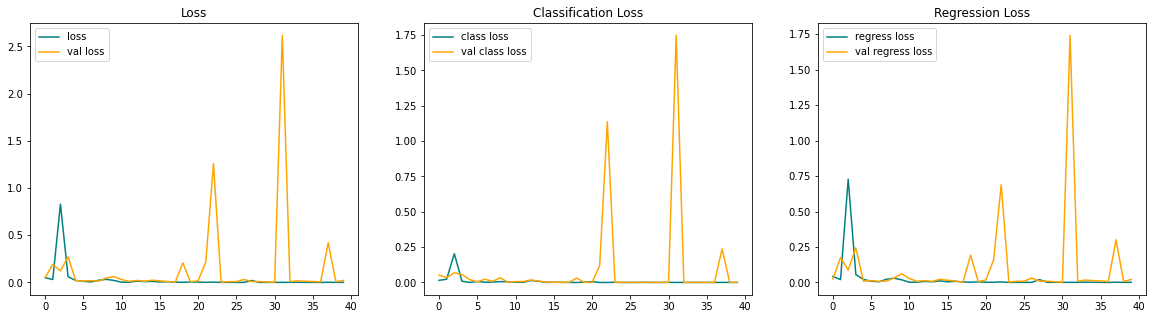

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [71]:
test_data = test_ds.as_numpy_iterator()

In [82]:
test_sample = test_data.next()

In [83]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 160ms/step


In [84]:
yhat

[array([[1.6428011e-04],
        [1.0000000e+00],
        [1.0000000e+00],
        [4.2578358e-06],
        [1.4569801e-04],
        [1.0000000e+00],
        [1.0000000e+00],
        [3.7570837e-05]], dtype=float32),
 array([[3.4092490e-03, 2.9377409e-03, 5.7101315e-03, 4.2985254e-03],
        [6.3769909e-04, 2.1876263e-02, 2.2142503e-01, 9.9160177e-01],
        [2.1556723e-03, 2.7573910e-03, 4.4302219e-01, 6.8961906e-01],
        [4.2927742e-04, 5.8820826e-04, 1.1591740e-03, 7.0473284e-04],
        [2.1170275e-03, 8.9461665e-04, 4.7745067e-03, 3.7430543e-03],
        [4.3238822e-01, 1.0960997e-01, 9.9772912e-01, 9.9707192e-01],
        [4.0661573e-01, 2.0335288e-01, 9.9382317e-01, 9.9415994e-01],
        [5.0278555e-04, 6.1192666e-04, 8.4946596e-04, 1.4605239e-03]],
       dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


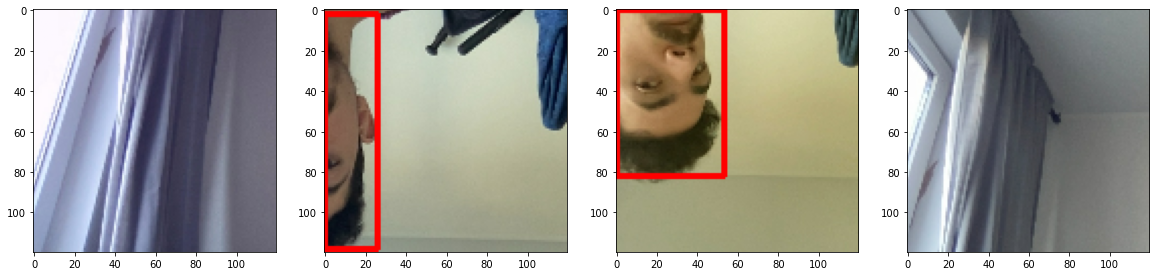

In [85]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [76]:
from tensorflow.keras.models import load_model

In [77]:
facetracker.save('facetracker.h5')

In [78]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [81]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step


1   HIToolbox                           0x000000019dfd6d4c _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 284
2   HIToolbox                           0x000000019deb0230 _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 40
3   HIToolbox                           0x000000019de1d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000019deb08a0 _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 216
5   HIToolbox                           0x000000019de13cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x000000019de47bb0 PostEventToQueueInternal + 696
7   HIToolbox                           0x000000019de49340 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 460
8   HIToolbox                           0x000000019de48c44 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 296
9   HIToolbox                           0x000000019de48ae0 _ZL14Messag

1/1 [==============================] - 0s 11ms/step


1   HIToolbox                           0x000000019de3b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000019de7a478 _ZL17BroadcastInternaljPvh + 184
3   SkyLight                            0x00000001993904dc _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 896
4   SkyLight                            0x000000019938f0d8 CGSSnarfAndDispatchDatagrams + 808
5   SkyLight                            0x00000001996b6a8c SLSGetNextEventRecordInternal + 344
6   SkyLight                            0x00000001994b85a4 SLEventCreateNextEvent + 16
7   HIToolbox                           0x000000019de48b58 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 60
8   HIToolbox                           0x000000019de48ae0 _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 60
9   CoreFoundation                      0x0000000194798420 __CFMachPortPerform + 260
10  CoreFoundation                      0x0000000194768fa8 __CFRUNLO

1/1 [==============================] - 0s 10ms/step


1   HIToolbox                           0x000000019deb05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000019de5327c SetMenuBarObscured + 224
3   HIToolbox                           0x000000019de52ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
4   HIToolbox                           0x000000019de4cfcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
5   HIToolbox                           0x000000019de13cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x000000019de4c96c AcquireEventFromQueue + 432
7   HIToolbox                           0x000000019de3bc84 ReceiveNextEventCommon + 320
8   HIToolbox                           0x000000019de3bb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
9   AppKit                              0x00000001979e8424 _DPSNextEvent + 632
10  AppKit                              0x00000001979e75b4 -[NSApplication(NSEvent) _ne

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1   HIToolbox                           0x000000019de3b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000019de53214 SetMenuBarObscured + 120
3   HIToolbox                           0x000000019de5a390 _ZN13HIApplication11FrontUILostEv + 44
4   HIToolbox                           0x000000019de5304c _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 528
5   HIToolbox                           0x000000019de4cf70 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 204
6   HIToolbox                           0x000000019de13cd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x000000019de4c96c AcquireEventFromQueue + 432
8   HIToolbox                           0x000000019de3bc84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x000000019de3bb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x00000001979e8424 _DPSNextEv

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1   HIToolbox                           0x000000019deb05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000019de5327c SetMenuBarObscured + 224
3   HIToolbox                           0x000000019de52ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
4   HIToolbox                           0x000000019de4cfcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
5   HIToolbox                           0x000000019de13cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x000000019de4c96c AcquireEventFromQueue + 432
7   HIToolbox                           0x000000019de3bc84 ReceiveNextEventCommon + 320
8   HIToolbox                           0x000000019de3bb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
9   AppKit                              0x00000001979e8424 _DPSNextEvent + 632
10  AppKit                              0x00000001979e75b4 -[NSApplication(NSEvent) _ne

1/1 [==============================] - 0s 11ms/step
